# ULMFiT + Siamese Network for Sentence Vectors
## Part Three: Classifying

The second notebook created a new language model from the SNLI dataset.
This notebook will adapt that model to predicting the SNLI category for sentence pairs.
The model will be used as a sentence encoder for a Siamese Network that builds sentence vectors that are feed into a classifier network.

In [1]:
from fastai.text import *
import html

import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
import random

import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
import data

snli_root = './data/snli_1.0/'
token_files = './data/tokens/'

## Create a new dataloader to create sentence pairs

In [2]:
class SiameseDataLoader():
    def __init__(self, sentence_pairs, pad_val, batch_size=32):
        self.sentence_pairs = sentence_pairs
        self.batch_size = batch_size
        self.index = 0
        self.pad_val = pad_val
     
    def shuffle(self):
        def srtfn(x):
            return x[:, -1] + random.randint(-5, 5)
        
        order = np.argsort(srtfn(self.sentence_pairs))
        self.sentence_pairs = self.sentence_pairs[order]
        
    def __iter__(self):
        return self
    
    def fill_tensor(self, sentences, max_len):
        data = np.zeros((max_len, len(sentences)), dtype=np.long)
        data.fill(self.pad_val)
        
        for i, s in enumerate(sentences): 
            start_idx = max_len - len(s)
            for j, p in enumerate(s):
                data[:,i][start_idx+j] = p
            
        return torch.LongTensor([data.tolist()]).cuda()
     
    def batch(self):
        return self.index//self.batch_size
    
    def __len__(self):
        return len(self.sentence_pairs)//self.batch_size
    
    def __next__(self):
        #how many examples to ananlyise for this round
        num = min(self.batch_size, len(self.sentence_pairs) - self.index)
        
        if num < 1:
            raise StopIteration  # signals "the end"
            
        #collect the sentences
        max_len = 0
        first = []
        second = []
        labels = torch.LongTensor(num)
        
        for i in range(num):
            a, b, l, _ = self.sentence_pairs[self.index + i]
            
            if len(a) > max_len:
                max_len = len(a)
            
            if len(b) > max_len:
                max_len = len(b)
            
            first.append(a)
            second.append(b)
            labels[i] = l
            
        self.index += num
             
        return (self.fill_tensor(first, max_len).cuda(),
                self.fill_tensor(second, max_len).cuda(),
                labels.cuda()
               )

In [3]:
itos = pickle.load(open(f'{token_files}itos.pkl', 'rb'))
stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
pad_tok = stoi['_pad_']

sentence_pairs_train = np.load(f'{token_files}snli_tok_train.npy')
sentence_pairs_dev = np.load(f'{token_files}snli_tok_dev.npy')
sentence_pairs_test = np.load(f'{token_files}snli_tok_test.npy')

def print_sentence(s):
    sentence = ""
    for tok in s:
        sentence += " "+itos[tok]
    print(sentence)

print_sentence(sentence_pairs_train[0][0])
print_sentence(sentence_pairs_train[0][1])

print_sentence(sentence_pairs_dev[0][0])
print_sentence(sentence_pairs_dev[0][1])

print_sentence(sentence_pairs_test[0][0])
print_sentence(sentence_pairs_test[0][1])

 x_bos a person on a horse jumps over a broken down airplane .
 x_bos a person is training his horse for a competition .
 x_bos two women are embracing while holding to go packages .
 x_bos the sisters are hugging goodbye while holding to go packages after just eating lunch .
 x_bos this church choir sings to the masses as they sing joyous songs from the book at a church .
 x_bos the church has cracks in the ceiling .


# Check the dataloader

In [4]:
training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
s = training_data.sentence_pairs[0][0]
t = training_data.fill_tensor([s], len(s))
for s in t[0]:
    print(itos[int(s[0])], end=' ')

x_bos a person on a horse jumps over a broken down airplane . 

## Siamese network

In [5]:
class SiameseClassifier(nn.Module):
    
    def __init__(self, encoder, linear):
        super().__init__()
        self.encoder = encoder
        self.linear = linear
    
    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)

    def pool_outputs(self, output):
        sl, bs,_ = output.size()
        #avgpool = self.pool(output, bs, False)
        maxpool = self.pool(output, bs, True)
        #return torch.cat([output[-1], maxpool, avgpool], 1)
        return maxpool
        
    def forward_once(self, input):
        raw_outputs, outputs = self.encoder(input)
        out = self.pool_outputs(outputs[-1])
        return out
    
    def forward(self, in1, in2):
        u = self.forward_once(in1)
        v = self.forward_once(in2)
        features = torch.cat((u, v, torch.abs(u-v), u*v), 1)
        out = self.linear(features)
        return out 
        
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

class LinearClassifier(nn.Module):
    def __init__(self, layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList([LinearBlock(layers[i], layers[i + 1], dropout) for i in range(len(layers) - 1)])
        
    def forward(self, input):
        x = input
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x


In [6]:
#these are the values used for the original LM
em_sz, nh, nl = 400, 1150, 3
bptt = 70
max_seq = bptt * 20
cats = 3

## Load our pretrained model then build the Siamese network from it

## Training loop
This should be converted over to the fast.ai learner but I'm not sure how to do that yet.

In [7]:
log_interval = 1000
criterion = nn.CrossEntropyLoss()
#criterion = nn.CosineEmbeddingLoss()

def evaluate(model, data_loader):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    total_loss = 0.
    num_correct = 0
    total = 0 
    
    for a, b, l in data_loader:
        
        model.reset()
        a, b, l = Variable(a), Variable(b), Variable(l)
        out = model(a.squeeze(), b.squeeze())
        loss = criterion(out, l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
    return (total_loss / total, num_correct / total)

def train(model, data_loader, optimizer):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    model.train() 
    
    total_loss = 0.
    num_correct = 0
    total = 0 
        
    for a, b, l in data_loader:
        optimizer.zero_grad()
        
        model.reset()
        a, b, l = Variable(a), Variable(b), Variable(l)
        out = model(a.squeeze(), b.squeeze())
        loss = criterion(out, l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
        loss.backward()
        optimizer.step()

        batch = data_loader.batch()
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / total
            elapsed = time.time() - start_time
            batches = len(data_loader)
            ms = elapsed * 1000 / log_interval
            print(f'| {batch:5d}/{batches:5d} batches', end=" ")
            print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f} acc {num_correct / total}')
            #print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f}')
            total_loss = 0
            total = 0
            num_correct = 0
            start_time = time.time()

In [8]:
best_loss = 100
def training_loop(model, epochs, optimizer, scheduler = None):
    
    global best_loss
    for epoch in range(epochs):

        print(f'Start epoch {epoch:3d} training with lr ', end="")
        for g in optimizer.param_groups:
            print(g['lr'], end=" ")
        print("")
        
        training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
        training_data.shuffle()

        epoch_start_time = time.time()
        
        train(siamese_model, training_data, optimizer)
        if scheduler != None:
            scheduler.step()

        dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
        val_loss, accuracy = evaluate(siamese_model, dev_data)

        delta_t = (time.time() - epoch_start_time)
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {delta_t:5.2f}s | valid loss {val_loss:5.2f} accuracy {accuracy} learning rates')
        for g in optimizer.param_groups:
            print(g['lr'])
        print('-' * 89)

        if val_loss < best_loss:
            best_loss = val_loss
            with open(f'./siamese_model{val_loss:0.2f}{accuracy:0.2f}.pt', 'wb') as f:
                torch.save(siamese_model, f)

In [9]:
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_loss(losses):
    plt.semilogx(losses[:,0], losses[:,1])
    plt.semilogx(losses[:,0], butter_lowpass_filtfilt(losses[:,1], 300, 5000))
    plt.show()

def find_lr(model, model_to_optim, data_loader):
    losses = []
    model.train() 
    criterion = nn.CrossEntropyLoss()
    lr = 0.00001
    for a, b, l in data_loader:
        optimizer = optim.SGD(model_to_optim.parameters(), lr=lr)
        #optimizer = optim.Adam(model_to_optim.parameters(), lr=lr)
        optimizer.zero_grad()
        
        model.reset()
        a, b, l = Variable(a), Variable(b), Variable(l)
        out = model(a.squeeze(), b.squeeze())
        loss = criterion(out, l.squeeze())
        
        los_val = loss.item()
        losses.append((lr, los_val))
        if los_val > 5:
            break
        
        loss.backward()
        optimizer.step()
        
        lr *= 1.05
    losses = np.array(losses)
    #plot_loss(losses)
    return losses

In [11]:
SNLI_LM = torch.load("snli_language_model.pt")

dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.1
SNLI_encoder = MultiBatchRNN(bptt, max_seq, vocab_size, em_sz, nh, nl, pad_tok, dropouti=dps[0], wdrop=dps[2], dropoute=dps[3], dropouth=dps[4])

SNLI_encoder.load_state_dict(SNLI_LM[0].state_dict())

#2 pooled vectors, of 3 times the embedding size
siamese_model = SiameseClassifier(SNLI_encoder, LinearClassifier(layers=[em_sz*4, nh, 3], dropout=0.1)).cuda()

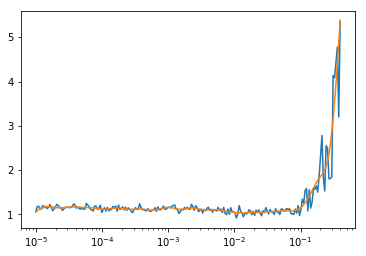

In [12]:
dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
losses = find_lr(siamese_model, siamese_model, dev_data)
plot_loss(np.array(losses))

In [13]:
siamese_model = SiameseClassifier(SNLI_encoder, LinearClassifier(layers=[em_sz*4, nh, 3], dropout=0.1)).cuda()

In [ ]:
#siamese_model = torch.load("siamese_model0.73.pt")

In [15]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = False

optimizer = optim.SGD(siamese_model.parameters(), lr=0.01)
training_loop(siamese_model.linear, 1, optimizer)

Start epoch   0 training with lr 0.01 
|  1000/17167 batches | ms/batch 15.29 | loss 0.8920 acc 0.59934375
|  2000/17167 batches | ms/batch 16.33 | loss 0.8808 acc 0.60240625
|  3000/17167 batches | ms/batch 16.95 | loss 0.8725 acc 0.6038125
|  4000/17167 batches | ms/batch 17.54 | loss 0.8861 acc 0.5920625
|  5000/17167 batches | ms/batch 17.97 | loss 0.8720 acc 0.60134375
|  6000/17167 batches | ms/batch 18.41 | loss 0.8790 acc 0.60025
|  7000/17167 batches | ms/batch 18.85 | loss 0.8780 acc 0.59765625
|  8000/17167 batches | ms/batch 19.40 | loss 0.8821 acc 0.59428125
|  9000/17167 batches | ms/batch 19.83 | loss 0.8848 acc 0.59696875
| 10000/17167 batches | ms/batch 20.40 | loss 0.8744 acc 0.5954375
| 11000/17167 batches | ms/batch 21.05 | loss 0.8753 acc 0.596875
| 12000/17167 batches | ms/batch 21.85 | loss 0.8786 acc 0.5935625
| 13000/17167 batches | ms/batch 22.62 | loss 0.8868 acc 0.590625
| 14000/17167 batches | ms/batch 23.55 | loss 0.8830 acc 0.59175
| 15000/17167 batches |

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = True

for lr in [0.01, 0.03, 0.05, 0.07, 0.09, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    optimizer = optim.SGD(siamese_model.parameters(), lr=lr)
    training_loop(siamese_model, 20, optimizer)

Start epoch   0 training with lr 0.01 
|  1000/17167 batches | ms/batch 31.02 | loss 0.7931 acc 0.6626875
|  2000/17167 batches | ms/batch 33.63 | loss 0.7997 acc 0.65134375
|  3000/17167 batches | ms/batch 35.14 | loss 0.7985 acc 0.64725
|  4000/17167 batches | ms/batch 36.65 | loss 0.8120 acc 0.640875
|  5000/17167 batches | ms/batch 37.83 | loss 0.8079 acc 0.6416875
|  6000/17167 batches | ms/batch 38.99 | loss 0.8127 acc 0.63871875
|  7000/17167 batches | ms/batch 40.04 | loss 0.8189 acc 0.633
|  8000/17167 batches | ms/batch 41.36 | loss 0.8203 acc 0.63290625
|  9000/17167 batches | ms/batch 42.39 | loss 0.8270 acc 0.63040625
| 10000/17167 batches | ms/batch 43.79 | loss 0.8158 acc 0.63325
| 11000/17167 batches | ms/batch 45.36 | loss 0.8184 acc 0.6334375
| 12000/17167 batches | ms/batch 47.25 | loss 0.8208 acc 0.631
| 13000/17167 batches | ms/batch 49.08 | loss 0.8318 acc 0.625
| 14000/17167 batches | ms/batch 51.23 | loss 0.8348 acc 0.62496875
| 15000/17167 batches | ms/batch 53

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.15 | loss 0.7419 acc 0.68596875
|  2000/17167 batches | ms/batch 33.79 | loss 0.7443 acc 0.68009375
|  3000/17167 batches | ms/batch 35.27 | loss 0.7545 acc 0.6748125
|  4000/17167 batches | ms/batch 36.81 | loss 0.7654 acc 0.667875
|  5000/17167 batches | ms/batch 37.96 | loss 0.7656 acc 0.6655
|  6000/17167 batches | ms/batch 39.01 | loss 0.7684 acc 0.66215625
|  7000/17167 batches | ms/batch 40.10 | loss 0.7758 acc 0.65915625
|  8000/17167 batches | ms/batch 41.39 | loss 0.7813 acc 0.656125
|  9000/17167 batches | ms/batch 42.44 | loss 0.7864 acc 0.65440625
| 10000/17167 batches | ms/batch 43.83 | loss 0.7824 acc 0.65353125
| 11000/17167 batches | ms/batch 45.40 | loss 0.7829 acc 0.65371875
| 12000/17167 batches | ms/batch 47.31 | loss 0.7846 acc 0.65296875
| 13000/17167 batches | ms/batch 49.14 | loss 0.7956 acc 0.64825
| 14000/17167 batches | ms/batch 51.28 | loss 0.8038 acc 0.64090625
| 15000/17167 batches | ms/batch 54.00 | loss 0.8049 acc 0.6

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.19 | loss 0.7016 acc 0.7098125
|  2000/17167 batches | ms/batch 33.83 | loss 0.7137 acc 0.69865625
|  3000/17167 batches | ms/batch 35.33 | loss 0.7233 acc 0.69090625
|  4000/17167 batches | ms/batch 36.89 | loss 0.7279 acc 0.6885625
|  5000/17167 batches | ms/batch 37.98 | loss 0.7333 acc 0.68228125
|  6000/17167 batches | ms/batch 39.12 | loss 0.7413 acc 0.67853125
|  7000/17167 batches | ms/batch 40.10 | loss 0.7450 acc 0.6763125
|  8000/17167 batches | ms/batch 41.48 | loss 0.7541 acc 0.67003125
|  9000/17167 batches | ms/batch 42.45 | loss 0.7611 acc 0.66671875
| 10000/17167 batches | ms/batch 43.93 | loss 0.7528 acc 0.67075
| 11000/17167 batches | ms/batch 45.49 | loss 0.7514 acc 0.66953125
| 12000/17167 batches | ms/batch 47.37 | loss 0.7606 acc 0.66553125
| 13000/17167 batches | ms/batch 49.12 | loss 0.7739 acc 0.6573125
| 14000/17167 batches | ms/batch 51.32 | loss 0.7750 acc 0.659125
| 15000/17167 batches | ms/batch 54.05 | loss 0.7803 acc 

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.22 | loss 0.6727 acc 0.7238125
|  2000/17167 batches | ms/batch 33.86 | loss 0.6886 acc 0.71209375
|  3000/17167 batches | ms/batch 35.38 | loss 0.6998 acc 0.70090625
|  4000/17167 batches | ms/batch 36.88 | loss 0.7058 acc 0.700125
|  5000/17167 batches | ms/batch 38.05 | loss 0.7068 acc 0.6966875
|  6000/17167 batches | ms/batch 39.11 | loss 0.7154 acc 0.69284375
|  7000/17167 batches | ms/batch 40.15 | loss 0.7232 acc 0.68696875
|  8000/17167 batches | ms/batch 41.47 | loss 0.7263 acc 0.68375
|  9000/17167 batches | ms/batch 42.52 | loss 0.7395 acc 0.6788125
| 10000/17167 batches | ms/batch 43.91 | loss 0.7347 acc 0.68146875
| 11000/17167 batches | ms/batch 45.48 | loss 0.7306 acc 0.6825625
| 12000/17167 batches | ms/batch 47.39 | loss 0.7373 acc 0.6795625
| 13000/17167 batches | ms/batch 49.24 | loss 0.7465 acc 0.6734375
| 14000/17167 batches | ms/batch 51.39 | loss 0.7545 acc 0.67146875
| 15000/17167 batches | ms/batch 54.12 | loss 0.7577 acc 0.

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.18 | loss 0.6294 acc 0.74484375
|  2000/17167 batches | ms/batch 33.84 | loss 0.6419 acc 0.73315625
|  3000/17167 batches | ms/batch 35.33 | loss 0.6584 acc 0.72403125
|  4000/17167 batches | ms/batch 36.84 | loss 0.6645 acc 0.72028125
|  5000/17167 batches | ms/batch 38.02 | loss 0.6605 acc 0.7186875
|  6000/17167 batches | ms/batch 39.08 | loss 0.6691 acc 0.71540625
|  7000/17167 batches | ms/batch 40.15 | loss 0.6784 acc 0.71065625
|  8000/17167 batches | ms/batch 41.45 | loss 0.6877 acc 0.70453125
|  9000/17167 batches | ms/batch 42.49 | loss 0.6952 acc 0.70153125
| 10000/17167 batches | ms/batch 43.89 | loss 0.6927 acc 0.705125
| 11000/17167 batches | ms/batch 45.48 | loss 0.6943 acc 0.702375
| 12000/17167 batches | ms/batch 47.36 | loss 0.7043 acc 0.6954375
| 13000/17167 batches | ms/batch 49.20 | loss 0.7096 acc 0.69225
| 14000/17167 batches | ms/batch 51.37 | loss 0.7207 acc 0.68825
| 15000/17167 batches | ms/batch 54.10 | loss 0.7205 acc 0.6

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.22 | loss 0.5350 acc 0.7873125
|  2000/17167 batches | ms/batch 33.84 | loss 0.5457 acc 0.7795625
|  3000/17167 batches | ms/batch 35.33 | loss 0.5596 acc 0.770875
|  4000/17167 batches | ms/batch 36.85 | loss 0.5603 acc 0.7710625
|  5000/17167 batches | ms/batch 38.06 | loss 0.5659 acc 0.76559375
|  6000/17167 batches | ms/batch 39.14 | loss 0.5665 acc 0.76803125
|  7000/17167 batches | ms/batch 40.16 | loss 0.5814 acc 0.75990625
|  8000/17167 batches | ms/batch 41.50 | loss 0.5839 acc 0.7569375
|  9000/17167 batches | ms/batch 42.61 | loss 0.5985 acc 0.75140625
| 10000/17167 batches | ms/batch 44.02 | loss 0.5945 acc 0.75275
| 11000/17167 batches | ms/batch 45.63 | loss 0.5988 acc 0.7475
| 12000/17167 batches | ms/batch 47.26 | loss 0.6037 acc 0.74709375
| 13000/17167 batches | ms/batch 49.25 | loss 0.6103 acc 0.74240625
| 14000/17167 batches | ms/batch 51.38 | loss 0.6296 acc 0.7379375
| 15000/17167 batches | ms/batch 54.06 | loss 0.6336 acc 0.729

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.23 | loss 0.5266 acc 0.78984375
|  2000/17167 batches | ms/batch 33.92 | loss 0.5413 acc 0.78084375
|  3000/17167 batches | ms/batch 35.41 | loss 0.5496 acc 0.77634375
|  4000/17167 batches | ms/batch 36.93 | loss 0.5505 acc 0.77153125
|  5000/17167 batches | ms/batch 38.05 | loss 0.5496 acc 0.7720625
|  6000/17167 batches | ms/batch 39.11 | loss 0.5591 acc 0.771125
|  7000/17167 batches | ms/batch 40.15 | loss 0.5714 acc 0.76240625
|  8000/17167 batches | ms/batch 41.47 | loss 0.5731 acc 0.7624375
|  9000/17167 batches | ms/batch 42.52 | loss 0.5860 acc 0.75675
| 10000/17167 batches | ms/batch 43.89 | loss 0.5841 acc 0.7561875
| 11000/17167 batches | ms/batch 45.47 | loss 0.5883 acc 0.75475
| 12000/17167 batches | ms/batch 47.39 | loss 0.5928 acc 0.7533125
| 13000/17167 batches | ms/batch 49.29 | loss 0.6013 acc 0.74671875
| 14000/17167 batches | ms/batch 51.49 | loss 0.6118 acc 0.7441875
| 15000/17167 batches | ms/batch 54.21 | loss 0.6127 acc 0.74

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Start epoch  14 training with lr 0.01 
|  1000/17167 batches | ms/batch 31.23 | loss 0.5172 acc 0.79334375
|  2000/17167 batches | ms/batch 33.89 | loss 0.5272 acc 0.7868125
|  3000/17167 batches | ms/batch 35.37 | loss 0.5404 acc 0.7786875
|  4000/17167 batches | ms/batch 36.79 | loss 0.5426 acc 0.77984375
|  5000/17167 batches | ms/batch 37.92 | loss 0.5405 acc 0.7803125
|  6000/17167 batches | ms/batch 39.03 | loss 0.5457 acc 0.7756875
|  7000/17167 batches | ms/batch 40.05 | loss 0.5560 acc 0.771875
|  8000/17167 batches | ms/batch 41.39 | loss 0.5626 acc 0.7638125
|  9000/17167 batches | ms/batch 42.44 | loss 0.5777 acc 0.76084375
| 10000/17167 batches | ms/batch 43.85 | loss 0.5704 acc 0.76421875
| 11000/17167 batches | ms/batch 45.35 | loss 0.5718 acc 0.7640625
| 12000/17167 batches | ms/batch 47.38 | loss 0.5828 acc 0.7566875
| 13000/17167 batches | ms/batch 49.20 | loss 0.5916 acc 0.7504375
| 14000/17167 batches | ms/batch 51.38 | loss 0.5991 acc 0.750875
| 15000/17167 batches

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 31.16 | loss 0.4697 acc 0.81365625
|  2000/17167 batches | ms/batch 33.81 | loss 0.4829 acc 0.80678125
|  3000/17167 batches | ms/batch 35.29 | loss 0.4911 acc 0.8004375
|  4000/17167 batches | ms/batch 36.79 | loss 0.4973 acc 0.80084375
|  5000/17167 batches | ms/batch 37.94 | loss 0.4947 acc 0.79840625
|  6000/17167 batches | ms/batch 39.10 | loss 0.5016 acc 0.79421875
|  7000/17167 batches | ms/batch 40.17 | loss 0.5064 acc 0.79109375
|  8000/17167 batches | ms/batch 41.38 | loss 0.5138 acc 0.78878125
|  9000/17167 batches | ms/batch 42.43 | loss 0.5229 acc 0.784125
| 10000/17167 batches | ms/batch 43.82 | loss 0.5265 acc 0.78553125
| 11000/17167 batches | ms/batch 45.50 | loss 0.5298 acc 0.7818125
| 12000/17167 batches | ms/batch 47.30 | loss 0.5344 acc 0.7796875
| 13000/17167 batches | ms/batch 49.14 | loss 0.5418 acc 0.776
| 14000/17167 batches | ms/batch 51.33 | loss 0.5532 acc 0.77009375
| 15000/17167 batches | ms/batch 54.08 | loss 0.5623 acc 0

KeyboardInterrupt: 

In [18]:
epochs = 10 
optimizer = optim.SGD(siamese_model.parameters(), lr=0.07)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.001)
training_loop(siamese_model, epochs, optimizer, scheduler)

Start epoch   0 training with lr 0.07 
|  1000/17167 batches | ms/batch 30.97 | loss 0.3957 acc 0.84734375
|  2000/17167 batches | ms/batch 33.69 | loss 0.4212 acc 0.833875
|  3000/17167 batches | ms/batch 35.29 | loss 0.4405 acc 0.82371875
|  4000/17167 batches | ms/batch 36.72 | loss 0.4443 acc 0.8230625
|  5000/17167 batches | ms/batch 37.84 | loss 0.4452 acc 0.82325
|  6000/17167 batches | ms/batch 38.95 | loss 0.4522 acc 0.81725
|  7000/17167 batches | ms/batch 40.00 | loss 0.4623 acc 0.81278125
|  8000/17167 batches | ms/batch 41.23 | loss 0.4709 acc 0.80628125
|  9000/17167 batches | ms/batch 42.29 | loss 0.4825 acc 0.80440625
| 10000/17167 batches | ms/batch 43.69 | loss 0.4764 acc 0.806875
| 11000/17167 batches | ms/batch 45.28 | loss 0.4846 acc 0.8019375
| 12000/17167 batches | ms/batch 47.21 | loss 0.4954 acc 0.79825
| 13000/17167 batches | ms/batch 49.10 | loss 0.4975 acc 0.79640625
| 14000/17167 batches | ms/batch 51.29 | loss 0.5128 acc 0.78984375
| 15000/17167 batches | 

KeyboardInterrupt: 

In [62]:
entailed_a = []
entailed_b = []
contra_a = []
contra_b = []
netural_a = []
netural_b = []

In [ ]:

def list2arr(l):
    "Convert list into pytorch Variable."
    return V(np.expand_dims(np.array(l), -1))

def make_prediction_from_list(model, l):
    """
    Encode a list of integers that represent a sequence of tokens.  The
    purpose is to encode a sentence or phrase.

    Parameters
    -----------
    model : fastai language model
    l : list
        list of integers, representing a sequence of tokens that you want to encode`

    """
    arr = list2arr(l)# turn list into pytorch Variable with bs=1
    model.reset()  # language model is stateful, so you must reset upon each prediction
    hidden_states = model(arr)[-1][-1] # RNN Hidden Layer output is last output, and only need the last layer

    #return avg-pooling, max-pooling, and last hidden state
    return hidden_states.mean(0), hidden_states.max(0)[0], hidden_states[-1]


def get_embeddings(encoder, list_list_int):
    """
    Vectorize a list of sequences List[List[int]] using a fast.ai language model.

    Paramters
    ---------
    encoder : sentence_encoder
    list_list_int : List[List[int]]
        A list of sequences to encode

    Returns
    -------
    tuple: (avg, mean, last)
        A tuple that returns the average-pooling, max-pooling over time steps as well as the last time step.
    """
    n_rows = len(list_list_int)
    n_dim = encoder.nhid
    avgarr = np.empty((n_rows, n_dim))
    maxarr = np.empty((n_rows, n_dim))
    lastarr = np.empty((n_rows, n_dim))

    for i in tqdm_notebook(range(len(list_list_int))):
        avg_, max_, last_ = make_prediction_from_list(encoder, list_list_int[i])
        avgarr[i,:] = avg_.data.cpu().numpy()
        maxarr[i,:] = max_.data.cpu().numpy()
        lastarr[i,:] = last_.data.cpu().numpy()

    return avgarr, maxarr, lastarr

def encode_sentences(sentences, encoding_dict):
    sentences_enc = []
    for sent in sentences:
        sent_enc = []
        for word in f'{BOS} ' +fixup(sent):
            sent_enc.append(encoding_dict[word])
        sentences_enc.append(sent_enc)
        
    return sentences_enc

In [ ]:
siamese_model = torch.load('siamese_model0.73.pt')
siamese_model.encoder.nhid = 400

In [ ]:
entailed_a_vec = get_embeddings(siamese_model.encoder, encode_sentences(entailed_a, stoi))
entailed_b_vec = get_embeddings(siamese_model.encoder, encode_sentences(entailed_b, stoi))

In [ ]:
import nmslib

def create_nmslib_search_index(numpy_vectors):
    """Create search index using nmslib.
    Parameters
    ==========
    numpy_vectors : numpy.array
        The matrix of vectors
    Returns
    =======
    nmslib object that has index of numpy_vectors
    """

    search_index = nmslib.init(method='hnsw', space='cosinesimil')
    search_index.addDataPointBatch(numpy_vectors)
    search_index.createIndex({'post': 2}, print_progress=True)
    return search_index

def percent_matching(query_vec, searchindex, k=10):
    num_found = 0
    num_total = len(query_vec)
    for i in range(num_total):
        query = query_vec[i]
        idxs, dists = searchindex.knnQuery(query, k=k)
        if i in idxs:
            num_found += 1

    return 100 * num_found/num_total


In [ ]:
entailed_b_max_searchindex = create_nmslib_search_index(entailed_b_vec[0])
percent_matching(entailed_a_vec[0], entailed_b_max_searchindex, 10)

In [ ]:
entailed_b_max_searchindex = create_nmslib_search_index(entailed_b_vec[1])
percent_matching(entailed_a_vec[1], entailed_b_max_searchindex, 20)

In [ ]:
entailed_b_last_searchindex = create_nmslib_search_index(entailed_b_vec[2])
percent_matching(entailed_a_vec[2], entailed_b_last_searchindex, 10)

In [ ]:
entailed_a_concat = np.concatenate((entailed_a_vec[0], entailed_a_vec[1], entailed_a_vec[2]), axis=1)
entailed_b_concat = np.concatenate((entailed_b_vec[0], entailed_b_vec[1], entailed_b_vec[2]), axis=1)
entailed_b_concat_searchindex = create_nmslib_search_index(entailed_b_concat)

In [ ]:
percent_matching(entailed_a_concat, entailed_b_concat_searchindex, 5)

In [ ]:
def show_similar(query, query_idx, searchindex):
    idx, _ = searchindex.knnQuery(query[query_idx], k=10)
    matched = []
    for i in idx:
        matched.append(entailed_b[i])
    
    match = query_idx in idx
    
    return match, entailed_a[query_idx], entailed_b[query_idx], matched

In [ ]:
for i in range(10):
    results = show_similar(entailed_a_vec[1], i, entailed_b_max_searchindex)
    if results[0]:
        print(results[1])
        print(results[2])
        for result in results[3]:
            print("\t"+result)
        print("")